<a href="https://colab.research.google.com/github/Hamzaman10/SYSC4906_Assignments/blob/main/SYSC4415W23_A3_Hamza_Zafar_101119026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SYSC 4415 Assignment 3
# Hamza Zafar
# 101119026

if running on your own machine you will need to change the file paths for the csv files

In [ ]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
import random
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, classification_report

In [ ]:

# Load extracted features and labels
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SYSC4415W23_A3_dataset/SYSC4415W23_A3_dataset/train/extracted_features.csv')
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SYSC4415W23_A3_dataset/SYSC4415W23_A3_dataset/train/labels.csv')

# get rid of features with missing values as that causes problems
features = features.dropna(axis=1)

# Sort features dataframe by sample_id to make things easier
features = features.sort_values(by='sample_id')

# Reset the index after sorting also to make things easier
features = features.reset_index(drop=True)

# Sort labels dataframe by sample_id
labels = labels.sort_values(by='sample_id')

# Reset the index after sorting
labels = labels.reset_index(drop=True)

In [ ]:
# Select the top 2000 features using selectKBest

selector = SelectKBest(score_func=f_classif, k=2000)
X_selected = selector.fit_transform(features.drop(columns='sample_id'), labels['label'])

#get an array of the selected features
selected_features_indices = selector.get_support(indices=True)


# Split the data into training and validation sets 80/20
X_train, X_val, y_train, y_val = train_test_split(X_selected, labels['label'], test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
#higher max_iter needed as Liblinear failed to converge with default 100
lr = LogisticRegression(solver='liblinear',max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Logistic Regression accuracy:', accuracy)


Logistic Regression accuracy: 0.7230769230769231


In [ ]:
# Random Forest
#n_estimator found using trial and error
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# Evaluate on validation set
y_pred = rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('Random Forest accuracy:', accuracy)

Random Forest accuracy: 0.7692307692307693


In [ ]:
# XGBoost
#n_estimator found using trial and error
xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Evaluate on validation set
y_pred = xgb.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('XGBOOST accuracy:', accuracy)


XGBOOST accuracy: 0.7661538461538462


In [ ]:
# SVM
#linear kernel gave best results by far, found using trial and error
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Evaluate on validation set
y_pred = svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print('svm accuracy:', accuracy)

svm accuracy: 0.7138461538461538


In [ ]:
# Implement majority voting for the model combination
def majority_voting(models, X):
    # Get predictions from each model
    preds = [model.predict(X) for model in models]

    # Initialize an empty list to store the majority votes
    majority_votes = []

    # Iterate over the range of the number of samples (rows) in the predictions
    for i in range(len(X)):

        #get the predictions from each model
        current_predictions = [pred[i] for pred in preds]

        #count the number of times a class was choses
        class_counts = np.bincount(current_predictions)

        #get the argmax of classes to find which one got the most votes
        #argmax handles ties by placing the class that appears first in the array
        #get higher accuracy when I do this so I'll leave it like that
        majority_vote = np.argmax(class_counts)

        #append the majority votes to the list
        majority_votes.append(majority_vote)

    return np.array(majority_votes)




Combined model accuracy: 0.796923076923077


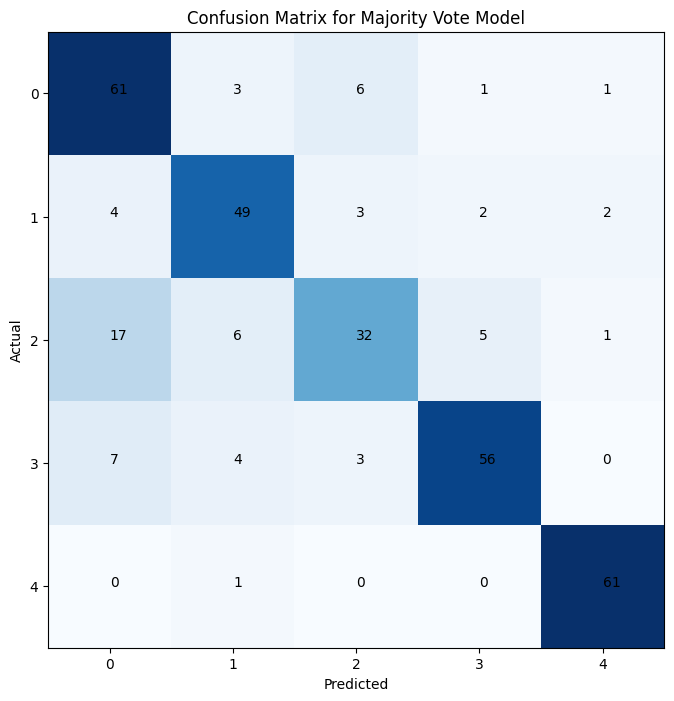

In [ ]:
# Evaluate the performance of the combined model and show results
models = [rf, xgb, svm, lr]
y_pred = majority_voting(models, X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"\nCombined model accuracy: {accuracy:}")

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
# Display the confusion matrix as an image with a blue colormap to make things easier to make out
im = ax.imshow(cm, cmap=plt.cm.Blues)
# Set the axis ticks, labels, and title
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xlabel='Predicted',
       ylabel='Actual',
       title='Confusion Matrix for Majority Vote Model')

# Loop over data dimensions and create text annotations.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], color="black")
plt.show()








In [ ]:
# Predict the labels for the test data
# Load test features
test_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SYSC4415W23_A3_dataset/SYSC4415W23_A3_dataset/test/extracted_features.csv')
test_features = test_features.dropna(axis=1)
#print("Original test features shape:", test_features.shape)

#make sure the test set features match with the ones used in the model because of the feature selection
selected_columns = selector.get_support(indices=True)
test_features_selected = test_features.iloc[:, selected_columns]
X_test = test_features_selected

#print("Selected test features shape:", X_test.shape)


In [ ]:
#make predictions
y_test_pred = majority_voting(models, X_test.values)

In [ ]:
# fill dataframe with sample_id's and predicted labels
test_labels = pd.DataFrame({'sample_id': test_features['sample_id'], 'label': y_test_pred})


In [ ]:
#export to a csv file
test_labels.to_csv('/content/drive/MyDrive/Colab Notebooks/group2_predictions.csv', index=False)

In [ ]:
# 5-fold cross-validation on the combined model
combined_model = VotingClassifier(estimators=[
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgboost', XGBClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='rbf', random_state=42, probability=True)),
    ('logistic_regression', LogisticRegression(solver='liblinear', max_iter=1000, random_state=42))
], voting='soft')



In [ ]:
#run cross-validation
#X_selected is the feature matrix with selected features, labels['label'] contains the target variable
cv_scores = cross_val_score(combined_model, X_selected, labels['label'], cv=5)

In [ ]:

#get predicted performance and add to csv file
predicted_performance = pd.DataFrame({
    'predicted_accuracy': [cv_scores.mean()],
    'predicted_accuracy_std': [cv_scores.std()]
})

print(cv_scores.mean())
print(cv_scores.std())

predicted_performance.to_csv('/content/drive/MyDrive/Colab Notebooks/group2_predicted_performance.csv', index=False)

0.792091168091168
0.026175701722294664
